In [3]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

paths = [['FER2013/train_FER2013', 'FER2013/validation_FER2013'], ['EiLA/EiLA_train', 'EiLA/EiLA_validation'], ['SFEW/Processed_Train_Faces', 'SFEW/Processed_Validation_Faces'], ['FER2013+10%EiLA/train', 'FER2013+10%EiLA/validation'], ['FER2013+30%EiLA/train', 'FER2013+30%EiLA/validation'], ['FER2013+50%EiLA/train', 'FER2013+50%EiLA/validation'],['FER2013+100%EiLA/train', 'FER2013+100%EiLA/validation'], ['SFEW+10%EiLA/train', 'SFEW+10%EiLA/validation'], ['SFEW+30%EiLA/train', 'SFEW+30%EiLA/validation'], ['SFEW+50%EiLA/train', 'SFEW+50%EiLA/validation'], ['SFEW+100%EiLA/train', 'SFEW+100%EiLA/validation']]
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
grandparent_dir = os.path.dirname(parent_dir)

# Load the demographics spreadsheet
demographics_df = pd.read_csv(os.path.join(grandparent_dir, 'EiLA/Extra/demographics.csv'))

In [4]:
import shutil

experiment = 3
train_dir = os.path.join(grandparent_dir, 'Experiment_Datasets', paths[experiment][0]) # select training dataset for this experiment
validation_dir = os.path.join(grandparent_dir, 'Experiment_Datasets', paths[experiment][1])  # select validation dataset for this experiment
test_dir = os.path.join(grandparent_dir, 'EiLA/Preprocessing/2.Resized_image/EiLA_test') # same for all experiments

print(train_dir)
print(validation_dir)

valid_emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

emotions = os.listdir(train_dir)

def clean_directory(directory, valid_emotions):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path) and item not in valid_emotions:
            shutil.rmtree(item_path)  # Remove invalid directories (e.g ipynb_checkpoints)
            
clean_directory(train_dir, valid_emotions)
clean_directory(validation_dir, valid_emotions)
clean_directory(test_dir, valid_emotions)

C:\Users\chena\Desktop\ResearchProject\Experiment_Datasets\FER2013+10%EiLA/train
C:\Users\chena\Desktop\ResearchProject\Experiment_Datasets\FER2013+10%EiLA/validation


In [5]:
from collections import defaultdict

def count_images(directory, valid_emotions):
    count = defaultdict(int)
    for emotion in valid_emotions:
        emotion_dir = os.path.join(directory, emotion)
        if os.path.isdir(emotion_dir):
            count[emotion] = len(os.listdir(emotion_dir))
    return count

train_counts = count_images(train_dir, valid_emotions)
valid_counts = count_images(validation_dir, valid_emotions)

print("Training set counts:", train_counts)
print("Validation set counts:", valid_counts)

Training set counts: defaultdict(<class 'int'>, {'Angry': 4089, 'Disgust': 445, 'Fear': 4104, 'Happy': 7320, 'Neutral': 5216, 'Sad': 4842, 'Surprise': 3175})
Validation set counts: defaultdict(<class 'int'>, {'Angry': 969, 'Disgust': 115, 'Fear': 1034, 'Happy': 1831, 'Neutral': 1272, 'Sad': 1250, 'Surprise': 840})


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import numpy as np

# Create a DataFrame to hold image paths and corresponding labels and demographics
def create_test_dataframe(data_dir, demographics_df):
    data = []
    for emotion in valid_emotions:
        emotion_dir = os.path.join(data_dir, emotion)
        if os.path.isdir(emotion_dir):
            for img_name in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_name)
                # Extract demographic information from file name
                id = img_name.split('.')[0].split('video_')[0].split('_label_')[0]
                label = img_name.split('.')[0].split('video_')[0].split('_label_')[1].split('_')[0]
                video_tag = img_name.split('.')[0].split('video_')[1].split('_clip_')[0]
                clip_id = int(img_name.split('.')[0].split('video_')[1].split('_clip_')[1].split('_person_')[0])
                person_id = int(img_name.split('.')[0].split('video_')[1].split('_clip_')[1].split('_person_')[1])       
                
                # Find the corresponding row in the demographics DataFrame
                demo_info = demographics_df[(demographics_df['Video Tag'] == video_tag) &
                                           (demographics_df['Clip Id'] == clip_id) &
                                           (demographics_df['Person Id'] == person_id)]
                if not demo_info.empty:
                    perceived_race = demo_info.iloc[0]['Perceived Race']
                    data.append((img_path, emotion, perceived_race))
    return pd.DataFrame(data, columns=['path', 'emotion', 'Skin_tone'])


datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_df = create_test_dataframe(test_dir, demographics_df)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

valid_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='path', 
    y_col='emotion',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

Found 29191 images belonging to 7 classes.
Found 7311 images belonging to 7 classes.
Found 815 validated image filenames belonging to 7 classes.


In [7]:
# test_df = create_test_dataframe('EiLA/EiLA_test', demographics_df)
test_df

,path,emotion,Skin_tone
0,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W
1,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W
2,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W
3,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W
4,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W
...,...,...,...
810,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W
811,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W
812,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W
813,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W


C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in 

Text(0, 0.5, 'Size')

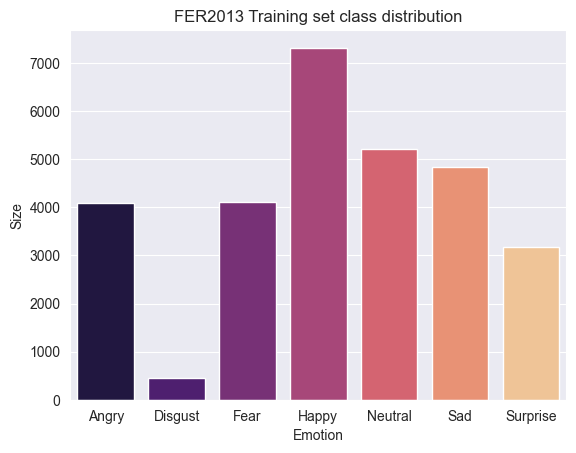

In [8]:
import matplotlib.pyplot as plt

emotions = os.listdir(train_dir)

train_counts = []
class_weights = {}

for emotion in emotions:
    if not emotion.endswith('checkpoints'):
        folder = os.path.join(train_dir, emotion)
        train_counts.append(len(os.listdir(folder)))

sns.barplot(x=emotions, y=train_counts, palette='magma').set_title("FER2013 Training set class distribution")
plt.xlabel('Emotion')
plt.ylabel('Size')


In [ ]:
validation_counts = []

for emotion in emotions:
    folder = os.path.join(validation_dir, emotion)
    validation_counts.append(len(os.listdir(folder)))
    
sns.barplot(x=emotions, y=validation_counts, palette='magma')

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adamax, SGD
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Input, Dense, Dropout
from tensorflow.keras.models import Sequential

input_shape = (224, 224, 3)  

base_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Fit the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

In [ ]:
# Unfreeze some layers in the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [ ]:
optimizer = Adamax(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model
history = model.fit(
    train_generator,
    epochs=35,
    validation_data=valid_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
# import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# sns.heatmap(df_cm, annot=True, fmt='g')
# Get the ground truth labels and predictions
test_labels = test_generator.classes
test_pred_probs = model.predict(test_generator)
test_preds = np.argmax(test_pred_probs, axis=1)

# Compute the F1 score
f1 = f1_score(test_labels, test_preds, average='weighted')
print(f'F1 Score: {f1}')

# Evaluate the model on the test set
results = model.evaluate(test_generator)

# Print all the metrics
for name, value in zip(model.metrics_names, results):
    print(f'{name}: {value}')

# Print classification report
print(classification_report(test_labels, test_preds, target_names=valid_generator.class_indices.keys()))

# Print confusion matrix
cm = confusion_matrix(test_labels, test_preds)
df_cm = pd.DataFrame(cm, index=[i for i in emotions],
                     columns=[i for i in emotions])
plt.figure(figsize=(12, 9))
plt.xlabel('Actual')
plt.ylabel('Predicted')
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
import numpy as np

# Get predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Create a DataFrame for the test results
test_df['predicted'] = predicted_classes
test_df['true'] = true_classes


# Calculate accuracy for each ethnic group
represented_races = ['B', 'W', 'M']
ethnic_results = {}
# 
for group in represented_races:
    group_df = test_df[test_df['Skin_tone'] == group]
    print(f'Size of group: {len(group_df)}')
    correct_predictions = np.sum(group_df['predicted'] == group_df['true'])
    incorrect_predictions = len(group_df) - correct_predictions
    ethnic_results[group] = correct_predictions / (correct_predictions + incorrect_predictions) * 100
    
# Display the accuracy for each ethnic group
for group, accuracy in ethnic_results.items():
    print(f'Accuracy for {group}: {accuracy:.2f}')

In [ ]:
correct_df = test_df[test_df['predicted'] == test_df['true']]
correct_df
incorrect_df = test_df[test_df['predicted'] != test_df['true']]
incorrect_df

In [ ]:
experiment_name = paths[experiment][0].split('/')[0]

if 'FER2013' in experiment_name:
    experiment_group = 'FER2013'
else:
    experiment_group = 'SFEW'
    
print(os.path.join(grandparent_dir, 'Experiment_Output/' + experiment_group, paths[experiment][0].split('/')[0] + '_correct.csv'))
correct_df.to_csv(os.path.join(grandparent_dir, 'Experiment_Output/' + experiment_group, paths[experiment][0].split('/')[0] + '_correct.csv'), sep=',', index=False, encoding='utf-8', na_rep='N/A')
incorrect_df.to_csv(os.path.join(grandparent_dir, 'Experiment_Output/' + experiment_group, paths[experiment][0].split('/')[0] + '_incorrect.csv'), sep=',', index=False, encoding='utf-8', na_rep='N/A')